# Importing Libraries

In [1]:
import numpy as np
import random
import gymnasium as gym
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

# Taxi-v3 Environment

(192, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})
Number of states: 500
Number of actions that an agent can take: 6
Action taken: West
Transition probability: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
Next state: 172
Reward recieved: -1
Terminal state: False
Decoded state: [1, 4, 3, 0]


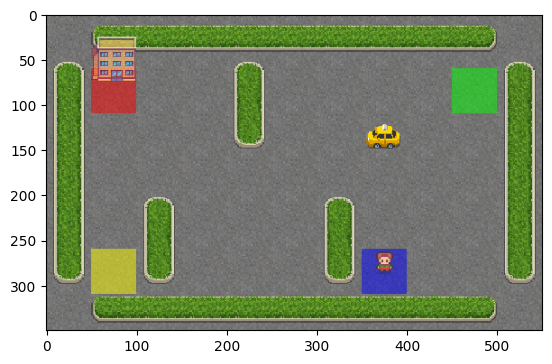

In [2]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
state = env.reset()

#Current State
print(state)

# 25 taxi positions x 5 possible passenger locations x 4 destination location = 500 states
print ("Number of states:", env.observation_space.n)

# Here, actions are one-step actions which can be performed by the agent
# The order of actions in the array below is according to Gymnasium docs
actions = ["South", "North", "East", "West", "Pick", "Drop"]
print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 5)
print("Action taken:", actions[rnd_action])
next_state, reward, is_terminal, is_truncated, t_prob = env.step(rnd_action)
print("Transition probability:", t_prob)
print("Next state:", next_state)
print("Reward recieved:", reward)
print("Terminal state:", is_terminal)

# Observation state returns an int(), it can be decoded to useful information using the decode method as shown below
# ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination --> [taxi_row, taxi_col, passenger_location, destination]
print("Decoded state:", list(env.decode(state[0])))

env_screen = env.render()
env.close()
plt.imshow(env_screen)
plt.show()

# Options

In [3]:
'''
Primitive options are special cases of options which last exactly one step.
Primitive options are South, North, East, West, Pick, Drop.
Rest of the options defined are multi-step i.e., temporally extended.
Temporally extended options are Opt_R, Opt_G, Opt_Y, Opt_B

These options correspond to [0,1,2,3,4,5,6,7,8,9] respectively.
'''

default_options = ["South", "North", "East", "West", "Pick", "Drop", 
           "Opt_R", "Opt_G", "Opt_Y", "Opt_B"]

Deterministic policies for the set of temporally extended options (`Opt_R`, `Opt_G`, `Opt_Y` and `Opt_B`) are used as is the case in the illustration example in [Between MDPs and semi-MDPs : A framework for temporal abstraction in reinforcement learning](https://people.cs.umass.edu/~barto/courses/cs687/Sutton-Precup-Singh-AIJ99.pdf). These policies are defined in the code cell below.

In [4]:
# 0: South, 1: North, 2: East, 3: West
# Here, the policy is defined as (x,y) location-action pair, this will be translated to state-action pair for options
# Deterministic policy which enables the agent to get goal R

Opt_R_policy = np.array([[1,3,0,0,0],
                         [1,3,0,0,0],
                         [1,3,3,3,3],
                         [1,1,1,1,1],
                         [1,1,1,1,1]])

# Deterministic policy which enables the agent to get goal G
Opt_G_policy = np.array([[0,0,2,2,1],
                         [0,0,2,2,1],
                         [2,2,2,1,1],
                         [1,2,1,1,1],
                         [1,2,1,1,1]])

# Deterministic policy which enables the agent to get goal Y
Opt_Y_policy = np.array([[0,3,0,0,0],
                         [0,3,0,0,0],
                         [0,3,3,3,3],
                         [0,1,1,1,3],
                         [0,1,3,1,3]])

# Deterministic policy which enables the agent to get goal B
Opt_B_policy = np.array([[0,0,0,0,3],
                         [0,0,0,0,3],
                         [2,2,2,0,3],
                         [1,1,1,0,3],
                         [1,1,1,0,3]])

In [5]:
def multistep_opt_default(option, state, environment, gamma):
    opt_done = False
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)} # 6,7,8,9 correspond to R,G,Y,B respectively
    option_policy_mapping = {6: Opt_R_policy, 7: Opt_G_policy, 8: Opt_Y_policy, 9: Opt_B_policy}
    cumulative_reward = 0
    timestep_count = 0
    while not opt_done:
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        action = option_policy_mapping[option][taxi_row][taxi_col]
        next_state, reward, done, _, _ = environment.step(action)
        timestep_count += 1
        cumulative_reward += (gamma**(timestep_count-1))*reward
        state = next_state
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        if (taxi_row, taxi_col) == goal_locations[option]:
            opt_done = True

    return state, cumulative_reward, timestep_count, done      

def opt_execute(option, state, environment):
    # Option has to be executed if the taxi is not in the corresponding location for the chosen option
    # Otherwise, it should not be executed
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)} # 6,7,8,9 correspond to R,G,Y,B respectively
    taxi_row, taxi_col, _, _ = list(environment.decode(state))
    if (taxi_row, taxi_col) == goal_locations[option]:
        return False # Do not execute chosen option
    else: 
        return True # Execute chosen option

# Policy over options (abbreviated as 'pop')
def epsilon_greedy_pop(Q_values, epsilon, options, state):
    rand = np.random.random()
    if rand < epsilon:
        return np.random.randint(0, len(options))
    else:
        return np.argmax(Q_values[state])

# SMDP Q-Learning

In [6]:
# Function for SMDP Q-Learning with Taxi-v3 Environment

def smdp_ql_taxi(num_episodes, alpha, gamma, epsilon, options, multistep_opt_config):

    environment = gym.make('Taxi-v3')
    Q_values = np.zeros((environment.observation_space.n, len(options)))
    episode_reward_list = []

    for ep in range(num_episodes):
        # Example of how state looks like for Gymnasium Taxi-v3
        # state_tuple = env.reset()
        # state_tuple = (443, {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)})
        # See https://gymnasium.farama.org/environments/toy_text/taxi/ for more details
        
        state_tuple = environment.reset() # state_tuple[0] would give the state integer value
        state = state_tuple[0]
        done = False
        episode_reward = 0

        while not done:

            # Choose option using policy over options
            option = epsilon_greedy_pop(Q_values, epsilon, options, state)

            # Check if the option is primitive/one-step
            if option < 6:
                next_state, reward, done, _, _ = environment.step(option) # r(s,o) is single step reward for primitive option
                # Conventional one-step Q-Learning update since primitive option
                # Q(s,o) update for primitive option
                Q_values[state, option] += alpha*(reward + gamma*max(Q_values[next_state,:] - 
                                                                     Q_values[state, option]))
                state = next_state
                episode_reward += reward
            
            # Multi-step option has been chosen
            else: 
                # Check if state is part of initiation set and decide if the option has to be executed or not
                execute_option = opt_execute(option, state, environment)
                if execute_option:
                    next_state, cumulative_reward, timesteps_elapsed, done = multistep_opt_config(option, state, environment, gamma) # r(s,o) is cumulative reward for multi-step options
                    # One-step SMDP Q-Learning update since multi-step option
                    # Q(s,o) update for multi-step option
                    Q_values[state, option] += alpha*(cumulative_reward + (gamma**timesteps_elapsed)*(max(Q_values[next_state,:])-
                                                                                                      Q_values[state, option]))
                    state = next_state
                    episode_reward += cumulative_reward
                else: 
                    state = next_state
                    done = False # done remains False since the state has not changed

        episode_reward_list.append(episode_reward)

    return episode_reward_list, Q_values

In [7]:
# Run SMDP Q-Learning

num_episodes = 2000
gamma = 0.9
epsilon = 0.1
alpha = 0.3

SMDP_episode_rewards, SMDP_Q_values = smdp_ql_taxi(num_episodes=num_episodes, alpha=alpha, gamma=gamma, 
                                                   epsilon=epsilon, options=default_options, multistep_opt_config = multistep_opt_default)

Text(0.5, 0, 'Episodes')

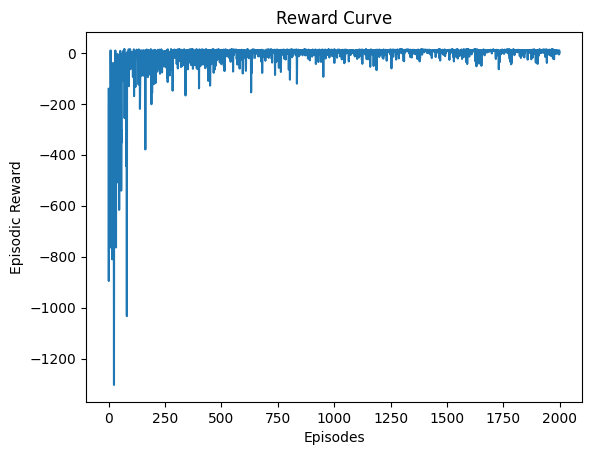

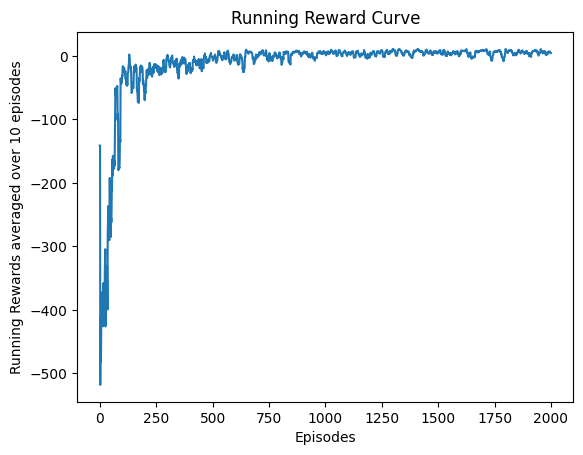

In [8]:
# Plot reward curve
plt.figure()
plt.plot(SMDP_episode_rewards)
plt.ylabel('Episodic Reward')
plt.title('Reward Curve')
plt.xlabel('Episodes')

SMDP_running_rewards = []
SMDP_running_rewards.append(SMDP_episode_rewards[0])
for i in range(1,num_episodes):
    SMDP_running_rewards.append(np.mean(SMDP_episode_rewards[max(0,i-10):i]))

plt.figure()
plt.plot(SMDP_running_rewards)
plt.ylabel('Running Rewards averaged over 10 episodes')
plt.title('Running Reward Curve')
plt.xlabel('Episodes')

In [9]:
# Visualize Q-table
df_SMDP_default = pd.DataFrame(SMDP_Q_values, columns = default_options)

df_SMDP_default.head()

,South,North,East,West,Pick,Drop,Opt_R,Opt_G,Opt_Y,Opt_B
0,-1.248194,-1.036233,-1.413006,-1.080154,-7.955751,-7.955751,0.0,-1.432415,-2.609545,-2.731855
1,-0.667097,1.018686,-1.966318,1.043846,7.905479,-4.849021,0.0,-12.274270,-4.611842,-10.332538
2,7.644327,-0.880770,5.223728,3.262923,15.869532,-8.807698,0.0,-9.911160,0.543204,-7.220438
3,3.527551,1.874201,2.669333,4.023339,10.819754,-7.460074,0.0,-8.853692,-4.111485,-6.601027
4,-2.209204,-1.111077,-2.213214,-1.111086,-11.111091,-11.110928,0.0,-6.405237,-5.240004,-10.216017


# Intra-Option Q-Learning

In [10]:
'''
An option can be written as a 3-tuple, o = <pi, beta, I>
where pi is the deterministic policy for the option
I is the set of initiation states, here it is every location other than the goal location for the respective option
beta is the termination condition for each state the option is valid in.
'''

def terminate_option(option, state, environment): # beta(state) --> termination condition 1 for terminate, 0 for continuing
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)} # 6,7,8,9 correspond to R,G,Y,B respectively

    taxi_row, taxi_col, _, _ = list(environment.decode(state)) # get current x,y location

    if option < 6: # Primitive option
        return 1 # Always terminate option after single-step since primitive option
    else: # Multi-step option
        if (taxi_row, taxi_col) == goal_locations[option]:
            return 1 # Terminate option if current location is the goal location for the chosen option
        else:
            return 0 # Continue

# returns a list of options for which the current state-action pair of the selected option also match.
def query_matching_options(action, state, selected_option, options, environment):

    options_ids = list(range(len(options)))
    nonselected_options = deepcopy(options_ids)
    nonselected_options.pop(selected_option)
    matching_options = [selected_option] # initialize with selected option
    x, y, _, _ = list(environment.decode(state))
    option_policy_mapping = {6: Opt_R_policy, 7: Opt_G_policy, 8: Opt_Y_policy, 9: Opt_B_policy}

    for o in nonselected_options:
        if o < 6 and o == action: # primitive options have mutually exclusive actions
            matching_options.append(o)
        elif o > 5: # check if the same state/location-action pair exists in the multi-step option policies
            if option_policy_mapping[o][x][y] == action: # It does not matter what the destination or location of the passenger is currently, for x, y deterministic policy makes only one action
                matching_options.append(o)

    return matching_options # includes the option selected by the 'policy over options'

def multistep_intra_opt_default(option, state, environment, gamma, options, Q_values):
    opt_done = False
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)} # 6,7,8,9 correspond to R,G,Y,B respectively
    option_policy_mapping = {6: Opt_R_policy, 7: Opt_G_policy, 8: Opt_Y_policy, 9: Opt_B_policy}
    cumulative_reward = 0
    timestep_count = 0
    while not opt_done:
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        action = option_policy_mapping[option][taxi_row][taxi_col]
        next_state, reward, done, _, _ = environment.step(action)
        matching_options = query_matching_options(action, state, action, options, environment)
        
        # Update Q(s,o) using one-step intra-option update rule as each step is executed
        for o in matching_options:
            beta = terminate_option(o, state, environment)
            Q_tilde = (1-beta)*Q_values[next_state, o] + beta*(max(Q_values[next_state, :]))
            Q_values[state, o] += alpha*(reward + gamma*Q_tilde - Q_values[state, o])            

        timestep_count += 1
        cumulative_reward += (gamma**(timestep_count-1))*reward
        state = next_state
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        if (taxi_row, taxi_col) == goal_locations[option]:
            opt_done = True

    return state, cumulative_reward, timestep_count, done

In [26]:
# Function for Intra-Option Q-Learning with Taxi-v3 Environment

def intraopt_ql_taxi(num_episodes, alpha, gamma, epsilon, options, multistep_opt_config):

    environment = gym.make('Taxi-v3')
    Q_values = np.zeros((environment.observation_space.n, len(options)))
    episode_reward_list = []

    for ep in range(num_episodes):
        # Example of how state looks like for Gymnasium Taxi-v3
        # state_tuple = env.reset()
        # state_tuple = (443, {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)})
        # See https://gymnasium.farama.org/environments/toy_text/taxi/ for more details
        
        state_tuple = environment.reset() # state_tuple[0] would give the state integer value
        state = state_tuple[0]
        done = False
        episode_reward = 0

        while not done:

            # Choose option using policy over options
            option = epsilon_greedy_pop(Q_values, epsilon, options, state)

            # Check if the option is primitive/one-step
            if option < 6:
                next_state, reward, done, _, _ = environment.step(option) # r(s,o) is single step reward for primitive option
                
                # Find options with the same state-action pairs
                matching_options = query_matching_options(option, state, option, options, environment)

                # One-step intra-option Q-Learning update for all options with the same action
                for o in matching_options:
                    beta = terminate_option(o, state, environment)
                    Q_tilde = (1-beta)*Q_values[next_state, o] + beta*(max(Q_values[next_state, :]))
                    Q_values[state, o] += alpha*(reward + gamma*Q_tilde - Q_values[state, o])

                state = next_state
                episode_reward += reward
            
            # Multi-step option has been chosen
            else: 
                # Check if state is part of initiation set and decide if the option has to be executed or not
                execute_option = opt_execute(option, state, environment)
                if execute_option:
                    # The function multistep_intra_opt updates Q values for options matching state-action pairs
                    next_state, cumulative_reward, timesteps_elapsed, done = multistep_opt_config(option, state, environment, gamma, options, Q_values) # r(s,o) is cumulative reward for multi-step options
                    # One-step Q-Learning update since multi-step option
                    # Q(s,o) update for multi-step option
                    
                    Q_values[state, option] += alpha*(cumulative_reward + (gamma**timesteps_elapsed)*(max(Q_values[next_state,:])-
                                                                                                      Q_values[state, option]))
                    state = next_state
                    episode_reward += cumulative_reward
                else: 
                    state = next_state
                    done = False # done remains False since the state has not changed

        episode_reward_list.append(episode_reward)

    return episode_reward_list, Q_values

In [27]:
# Run intra-option Q-Learning

num_episodes = 2000
gamma = 0.9
epsilon = 0.1
alpha = 0.1

intraopt_episode_rewards, intraopt_Q_values = intraopt_ql_taxi(num_episodes=num_episodes, alpha=alpha, gamma=gamma, 
                                                   epsilon=epsilon, options=default_options, multistep_opt_config = multistep_intra_opt_default)

Text(0.5, 0, 'Episodes')

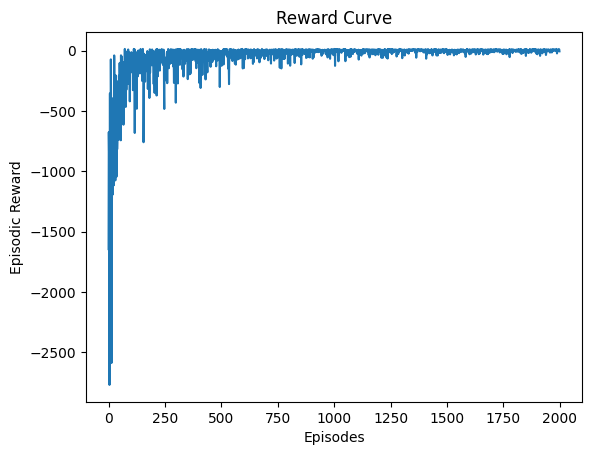

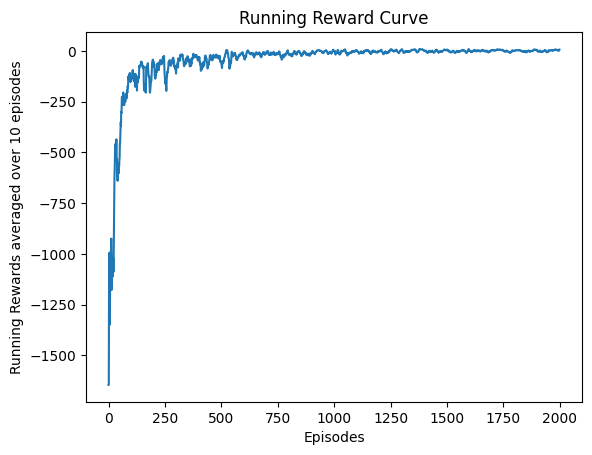

In [28]:
# Plot reward curve
plt.figure()
plt.plot(intraopt_episode_rewards)
plt.ylabel('Episodic Reward')
plt.title('Reward Curve')
plt.xlabel('Episodes')

intraopt_running_rewards = []
intraopt_running_rewards.append(intraopt_episode_rewards[0])
for i in range(1,num_episodes):
    intraopt_running_rewards.append(np.mean(intraopt_episode_rewards[max(0,i-10):i]))

plt.figure()
plt.plot(intraopt_running_rewards)
plt.ylabel('Running Rewards averaged over 10 episodes')
plt.title('Running Reward Curve')
plt.xlabel('Episodes')

In [29]:
# Visualize Q-table

df_intraopt_default = pd.DataFrame(intraopt_Q_values, columns = default_options)

df_intraopt_default.head()

,South,North,East,West,Pick,Drop,Opt_R,Opt_G,Opt_Y,Opt_B
0,-0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.246274,-0.206288,-0.211250
1,-1.995096,-2.873029,-2.991391,-2.554029,1.619974,-5.805116,-2.873029,-5.384240,-4.650082,-6.593331
2,0.669880,0.448566,-1.616225,-0.450284,7.714683,-3.588527,0.448566,-3.386000,-2.957065,-4.913747
3,-1.181272,-1.605447,-1.691783,-1.343286,2.913985,-4.642629,-1.605447,-4.250389,-3.199676,-3.463068
4,-4.691889,-4.690945,-4.683453,-4.690945,-4.774591,-4.879518,-4.690945,-5.350466,-5.154134,-5.202028


# Alternative Set of Options

In [15]:
# 0: South, 1: North, 2: East, 3: West
# Here, the policy is defined as (x,y) location-action pair, this will be translated to state-action pair for options
# Deterministic policy which enables the agent to get goal R

# Deterministic policy to always move South
Opt_S_policy = np.array([[0,0,0,0,0],
                         [0,0,0,0,0],
                         [0,0,0,0,0],
                         [0,0,0,0,0],
                         [0,0,0,0,0]])

# Deterministic policy to always move North
Opt_N_policy = np.array([[1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1]])

# Deterministic policy to always move East
Opt_E_policy = np.array([[2,2,2,2,2],
                         [2,2,2,2,2],
                         [2,2,2,2,2],
                         [2,2,2,2,2],
                         [2,2,2,2,2]])

# Deterministic policy to always move West
Opt_W_policy = np.array([[3,3,3,3,3],
                         [3,3,3,3,3],
                         [3,3,3,3,3],
                         [3,3,3,3,3],
                         [3,3,3,3,3],])

alternate_options = ["South", "North", "East", "West", "Pick", "Drop", 
           "Opt_South", "Opt_North", "Opt_East", "Opt_West"]

In [16]:
def multistep_opt_alternative(option, state, environment, gamma):
    opt_done = False
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)}  # 6,7,8,9 correspond to R,G,Y,B respectively
    goals_list = np.array([[0,0], [0,4], [4,0], [4,3]])
    option_policy_mapping = {6: Opt_S_policy, 7: Opt_N_policy, 8: Opt_E_policy, 9: Opt_W_policy}
    cumulative_reward = 0
    timestep_count = 0
    while not opt_done:
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        action = option_policy_mapping[option][taxi_row][taxi_col]
        next_state, reward, done, _, _ = environment.step(action)
        timestep_count += 1
        cumulative_reward += (gamma**(timestep_count-1))*reward        
        taxi_row_next, taxi_col_next, _, _ = list(environment.decode(next_state))
        
        # Terminate the option when it reaches either of the four destination/location states or when the taxi hits a wall
        if (taxi_row_next, taxi_col_next) == goal_locations[option] or (taxi_row_next, taxi_col_next) == (taxi_row, taxi_col):
            opt_done = True
        
        state = next_state

    return state, cumulative_reward, timestep_count, done

def multistep_intra_opt_alternative(option, state, environment, gamma, options, Q_values):
    opt_done = False
    goal_locations = {6:(0,0), 7:(0,4), 8:(4,0), 9:(4,3)} # 6,7,8,9 correspond to R,G,Y,B respectively
    option_policy_mapping = {6: Opt_S_policy, 7: Opt_N_policy, 8: Opt_E_policy, 9: Opt_W_policy}
    cumulative_reward = 0
    timestep_count = 0
    while not opt_done:
        taxi_row, taxi_col, _, _ = list(environment.decode(state))
        action = option_policy_mapping[option][taxi_row][taxi_col]
        next_state, reward, done, _, _ = environment.step(action)
        matching_options = query_matching_options(action, state, action, options, environment)
        
        # Update Q(s,o) using one-step intra-option update rule as each step is executed
        for o in matching_options:
            beta = terminate_option(o, state, environment)
            Q_tilde = (1-beta)*Q_values[next_state, o] + beta*(max(Q_values[next_state, :]))
            Q_values[state, o] += alpha*(reward + gamma*Q_tilde - Q_values[state, o])            

        timestep_count += 1
        cumulative_reward += (gamma**(timestep_count-1))*reward
        state = next_state
        taxi_row_next, taxi_col_next, _, _ = list(environment.decode(next_state))
        
        # Terminate the option when it reaches either of the four destination/location states or when the taxi hits a wall
        if (taxi_row_next, taxi_col_next) == goal_locations[option] or (taxi_row_next, taxi_col_next) == (taxi_row, taxi_col):
            opt_done = True

    return state, cumulative_reward, timestep_count, done

In [17]:
# SMDPQL with alternative set of options, reward curve and Q-table

num_episodes = 2000
gamma = 0.9
epsilon = 0.1
alpha = 0.3

SMDP_episode_rewards_alternate, SMDP_Q_values_alternate = smdp_ql_taxi(num_episodes=num_episodes, alpha=alpha, gamma=gamma, 
                                                   epsilon=epsilon, options=alternate_options, multistep_opt_config = multistep_opt_alternative)


,South,North,East,West,Pick,Drop,Opt_South,Opt_North,Opt_East,Opt_West
0,-0.848919,-1.615596,-1.337896,-0.912280,-8.807698,-8.986451,0.0,-0.795575,-1.612991,-1.510355
1,-2.222222,4.759288,-2.222222,1.483082,9.608122,-6.623157,0.0,5.749882,-3.456790,1.435891
2,-1.436117,-1.103885,4.691529,2.995084,15.171468,-6.920173,0.0,2.989010,-3.436381,2.958791
3,-2.222222,7.357228,3.307367,4.418481,11.840388,-6.372989,0.0,2.076542,1.686675,-1.111111
4,-2.222222,-1.111111,-2.222222,-1.111111,-11.111111,-11.111111,0.0,-1.111111,-3.456790,-1.111111


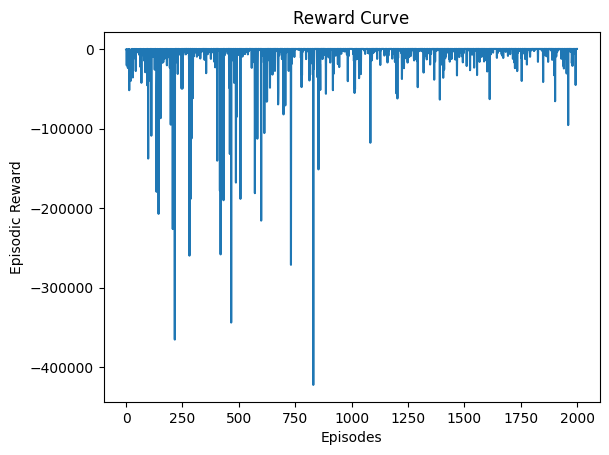

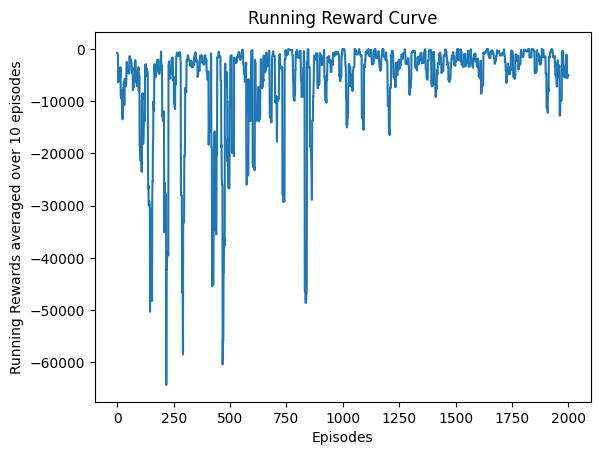

In [18]:
# Plot reward curve
plt.figure()
plt.plot(SMDP_episode_rewards_alternate)
plt.ylabel('Episodic Reward')
plt.title('Reward Curve')
plt.xlabel('Episodes')

SMDP_running_rewards_alternate = []
SMDP_running_rewards_alternate.append(SMDP_episode_rewards_alternate[0])
for i in range(1,num_episodes):
    SMDP_running_rewards_alternate.append(np.mean(SMDP_episode_rewards_alternate[max(0,i-10):i]))

plt.figure()
plt.plot(SMDP_running_rewards_alternate)
plt.ylabel('Running Rewards averaged over 10 episodes')
plt.title('Running Reward Curve')
plt.xlabel('Episodes')

# Visualize Q-table
df_SMDP_alternate = pd.DataFrame(SMDP_Q_values_alternate, columns = alternate_options)
df_SMDP_alternate.head()


In [19]:
# IOQL with alternative set of options, reward curve and Q-table

# Run intra-option Q-Learning

num_episodes = 2000
gamma = 0.9
epsilon = 0.1
alpha = 0.3

intraopt_episode_rewards_alternate, intraopt_Q_values_alternate = intraopt_ql_taxi(num_episodes=num_episodes, alpha=alpha, gamma=gamma, 
                                                   epsilon=epsilon, options=alternate_options, multistep_opt_config = multistep_intra_opt_alternative)

,South,North,East,West,Pick,Drop,Opt_South,Opt_North,Opt_East,Opt_West
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-4.075582,-0.327876,-1.073328,-0.044813,1.622615,-7.908366,-0.327876,-2.285519,-3.012454,-2.205244
2,0.132651,2.041785,1.146707,3.351114,8.619220,-3.026747,2.041785,-0.186672,-3.127499,2.635949
3,-2.635283,-1.875545,-3.835793,0.674580,2.914016,-7.640642,-1.875545,-4.674214,-4.742541,-0.928545
4,-5.651843,-6.259683,-6.127292,-6.193449,-10.501428,-11.500940,-6.259683,-6.767898,-6.418815,-6.756050


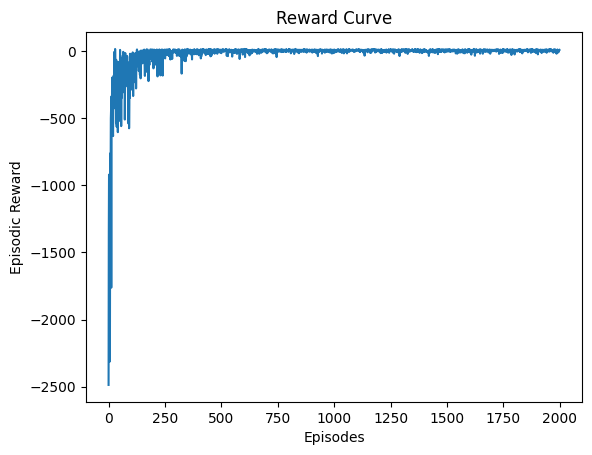

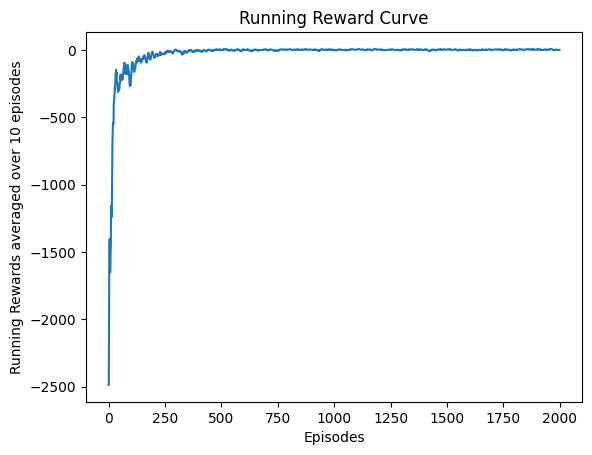

In [20]:
# Plot reward curve
plt.figure()
plt.plot(intraopt_episode_rewards_alternate)
plt.ylabel('Episodic Reward')
plt.title('Reward Curve')
plt.xlabel('Episodes')

intraopt_running_rewards_alternate = []
intraopt_running_rewards_alternate.append(intraopt_episode_rewards_alternate[0])
for i in range(1,num_episodes):
    intraopt_running_rewards_alternate.append(np.mean(intraopt_episode_rewards_alternate[max(0,i-10):i]))

plt.figure()
plt.plot(intraopt_running_rewards_alternate)
plt.ylabel('Running Rewards averaged over 10 episodes')
plt.title('Running Reward Curve')
plt.xlabel('Episodes')

# Visualize Q-table

df_intraopt_alternate = pd.DataFrame(intraopt_Q_values_alternate, columns = alternate_options)
df_intraopt_alternate.head()

# Comparison of algorithms

Below is the comparison of all four algorithms -
1. SMDP Q-Learning with default options (`SMDPQL_DEFAULT`)
2. Intra-option Q-Learning with default options (`IOQL_DEFAULT`)
3. SMDP Q-Learning with alternate options (`SMDPQL_ALTER`)
4. Intra-option Q-Learning with alternate options (`IOQL_ALTER`)

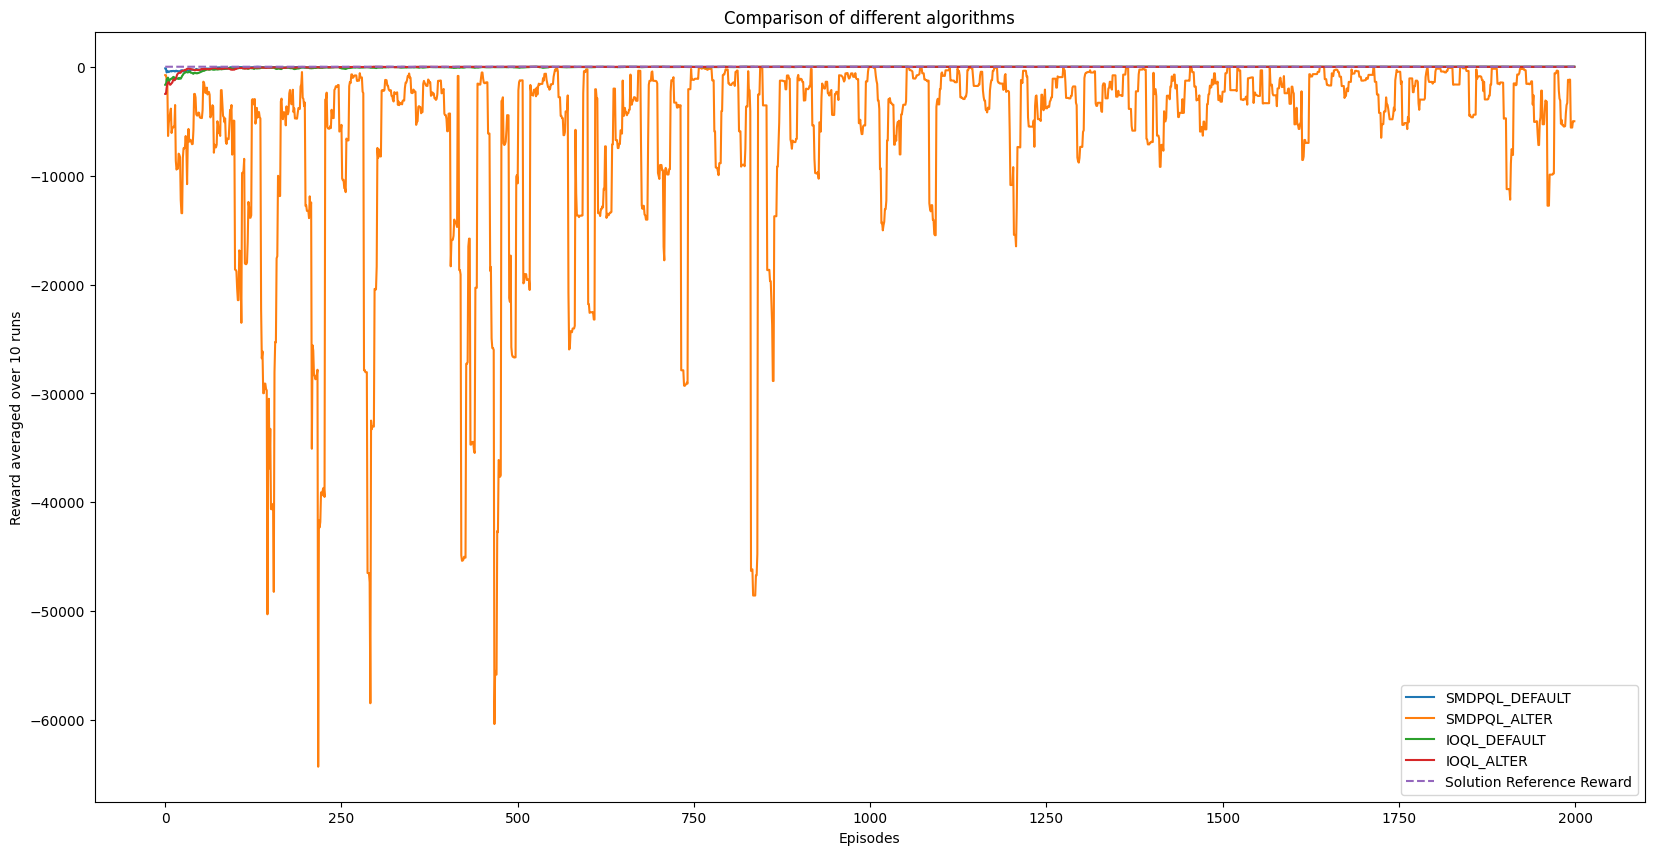

In [30]:
plt.figure(figsize = (20,10))
plt.plot(SMDP_running_rewards,label = 'SMDPQL_DEFAULT')
plt.plot(SMDP_running_rewards_alternate ,label = 'SMDPQL_ALTER')
plt.plot(intraopt_running_rewards,label = 'IOQL_DEFAULT')
plt.plot(intraopt_running_rewards_alternate,label = 'IOQL_ALTER')
plt.plot([10 for i in range(2000)],'--',label = 'Solution Reference Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward averaged over 10 runs')
plt.title('Comparison of different algorithms')
plt.legend()

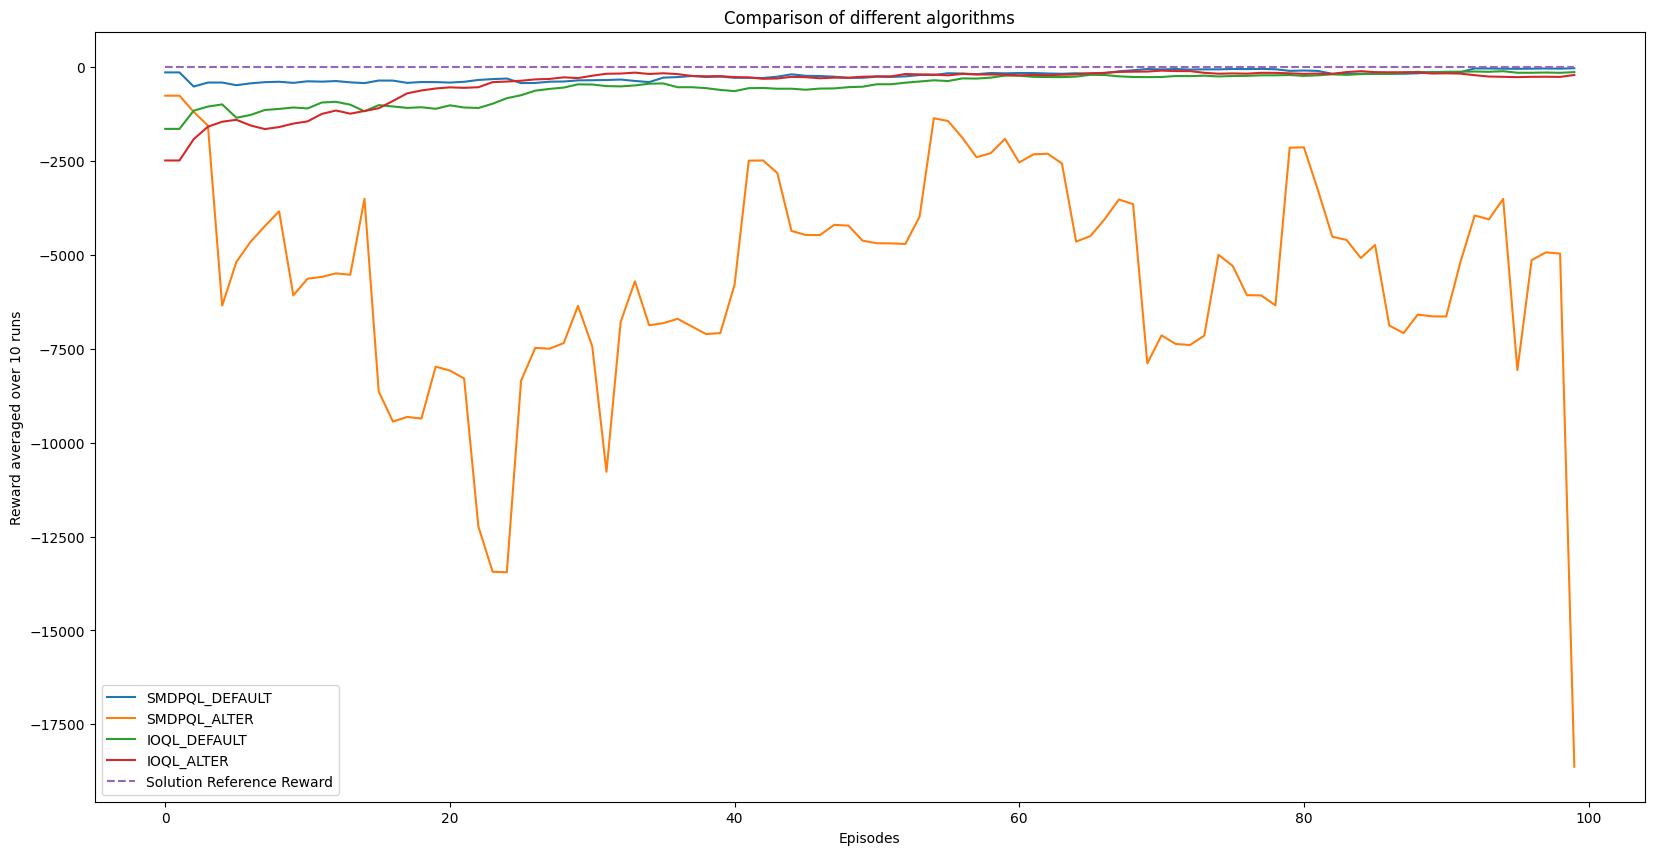

In [31]:
plt.figure(figsize = (20,10))
plt.plot(SMDP_running_rewards[:100],label = 'SMDPQL_DEFAULT')
plt.plot(SMDP_running_rewards_alternate[:100] ,label = 'SMDPQL_ALTER')
plt.plot(intraopt_running_rewards[:100],label = 'IOQL_DEFAULT')
plt.plot(intraopt_running_rewards_alternate[:100],label = 'IOQL_ALTER')
plt.plot([10 for i in range(100)],'--',label = 'Solution Reference Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward averaged over 10 runs')
plt.title('Comparison of different algorithms')
plt.legend()